<center>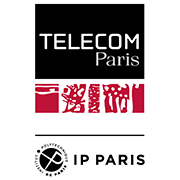</center>

<h1><center><strong><font color="green">IA 717: Linguistic Differences of Human-Human and AI-Generated Conversations</font></strong></center></h1>
<h3><center><font color="blue"><strong>Student Version</strong></font></center></h3>

<center>
<h3> Project Supervisor <br/> <a>Yi YU</a></h3>
<email>yi.yu@inria.fr</email>
<br/>

Year 2025-2026
</center>

------------------------

# <font color="green">**Context & Objectives**</font>

> The application of large language models (LLMs) in dialogue-based scenarios has become part of daily life since 2023. Human-LLM corpora are now available and enable the study on differences between Human-Human conversations and those generated by LLMs. The differences between these conversations can provide insights into potential alignment direction for current LLM-based chatbot with human expectations.

The objective of this project is to study the linguistic difference between two chosen corpora, <a href="https://github.com/facebookresearch/EmpatheticDialogues">EmpathicDialogues</a> and <a href="https://github.com/morganlee123/2GPTEmpathicDialogues">2GPTEmpathicDialogues</a>. The second is created as a replica of the first one by prompting two independent instances of ChatGPT. 

The following image provides an example of two conversations genereated under the same scenario, one by human, the other by ChatGPT.
![image.png](https://github.com/morganlee123/2GPTEmpathicDialogues/blob/main/paperfigures/exampledialogue.png?raw=true) 

We will first start with an exploration of basic concepts for conversation analysis (e.g. nb of turns per conversation, avg words per turn, etc.) and understand what has been studied within these two corpora in <a href="https://arxiv.org/abs/2401.16587">this paper</a>. We will then compare these two corpora on our own, focusing on one linguistic feature for affect study introduced later and calculate it for each conversation.

1) explore the mentioned corpora
2) analyze the general information about each corpus: the size of corpus and the setting used for the corpus creation 
3) study one linguistic feature for collaborative state analysis, <a href="https://www.liwc.app/help/lsm">language style matching</a>, calculate it for each pair of participants, human or ChatGPT, and finally compare the level of matching between two corpora
4) build a baseline model for LLM-generated dialogue detection using only word embedding as feature
5) add the calculated feature from step <a>3</a> to your baseline model to see if there is any improvement in performance
6) highlight your findings during the experiment


### <font color="green">Evaluation</font>

The project is evaluated through a presentation with a report and your completed project. Grades will be partly individual and partly collective. 

# <font color="green">**1 & 2 - Data Retrieval & Analysis**</font>

We need to download the two mentioned corpora using the link provided earlier. Each conversation in EmpatheticDialogue should be paired with a conversation in 2GPTEmpathicDialogues. Check if any conversation cannot be paired

<font color="red"> 1.1 Question: </font>  
Preprocessing and Data Exploration — Answer the following:

- How many conversations in EmpatheticDialogue can be paired with those in 2GPTEmpathicDialogues?  
- What is the average number of turns per conversation in each corpus?  
- What is the average number of words per conversation in both corpora?  
- How are conversations distributed across different emotional contexts (e.g., annoyed, proud, furious)?  

Present your findings using appropriate graphs and visualizations where possible.

<font color="orange">1.1 Answer:</font> 

In [1]:
# imports
import pandas as pd
import numpy as np

## Import des datas

On ignore les dernières colonnes à l'import de human_valid et human_test (non utiles pour le projet + erreurs de parsing)
On ignore les double-quotes pour human pour prendre en compte tous les séparateurs

In [2]:
# read data
dial_gpt = pd.read_csv("../data/2GPTEmpathicDialoguesDataset.csv")
dial_human = pd.read_csv("../data/empatheticdialogues/train.csv", quoting=3, usecols=[0,1,2,3,4,5])
dial_human_valid = pd.read_csv("../data/empatheticdialogues/valid.csv", quoting=3, usecols=[0,1,2,3,4,5])
dial_human_test = pd.read_csv("../data/empatheticdialogues/test.csv", quoting=3, usecols=[0,1,2,3,4,5])


In [3]:
# describe data
dial_human.info()
print("\n")
dial_human_valid.info()
print("\n")
dial_human_test.info()
print("\n")
dial_gpt.info()
print("\n")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84169 entries, 0 to 84168
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   conv_id        84169 non-null  object
 1   utterance_idx  84169 non-null  int64 
 2   context        84169 non-null  object
 3   prompt         84169 non-null  object
 4   speaker_idx    84169 non-null  int64 
 5   utterance      84169 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.9+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12078 entries, 0 to 12077
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   conv_id        12078 non-null  object
 1   utterance_idx  12078 non-null  int64 
 2   context        12078 non-null  object
 3   prompt         12078 non-null  object
 4   speaker_idx    12078 non-null  int64 
 5   utterance      12078 non-null  object
dtypes: int64(2), object(4)
memory usage: 56

In [4]:
# Empilement des tables test, valid et train pour s'assurer d'avoir le maximum de données communes
dial_human_tot = pd.concat([dial_human, dial_human_valid, dial_human_test])


In [5]:
dial_gpt.head()
dial_human.head()

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.


Les data ne sont pas sur le même format :
- chaque observation pour dial_gpt correspond à un dialogue
- chaque observation pour dial_human correspond à une prise de parole

> On cherche donc à transformer la table "dial_gpt" de manière à pouvoir faire une jointure avec la table "dial_human"
> 
> - On suppose que la clé de conv_id permettra de faire la jointure
> - Mais il faut au préalable éclater la colonne "processed" 

In [6]:
dial_gpt['processed_split'] = dial_gpt['processed'].str.split("\n")
dial_gpt2 = dial_gpt.explode('processed_split')
dial_gpt2 = dial_gpt2[dial_gpt2['processed_split'] != ""]
dial_gpt2['utterance_idx'] = dial_gpt2.groupby('conv_id').cumcount() + 1
dial_gpt2['speaker_idx'] = dial_gpt2['utterance_idx'] % 2
dial_fusion = pd.merge(dial_gpt2, dial_human_tot, how="outer", on=["conv_id", "utterance_idx"])


In [8]:
# Vérification des contextes
pd.crosstab(dial_fusion['context_x'], dial_fusion['context_y'])

context_y,afraid,angry,annoyed,anticipating,anxious,apprehensive,ashamed,caring,confident,content,...,joyful,lonely,nostalgic,prepared,proud,sad,sentimental,surprised,terrified,trusting
context_x,,,,,,,,,,,,,,,,,,,,,
afraid,2692,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
angry,0,2894,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
annoyed,0,0,2824,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
anticipating,0,0,0,2556,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
anxious,0,0,0,0,2603,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
apprehensive,0,0,0,0,0,1978,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ashamed,0,0,0,0,0,0,2126,0,0,0,...,0,0,0,0,0,0,0,0,0,0
caring,0,0,0,0,0,0,0,2217,0,0,...,0,0,0,0,0,0,0,0,0,0
confident,0,0,0,0,0,0,0,0,2601,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
print("Nombre de conversations communes aux deux bases : ", len(set(dial_gpt2["conv_id"]).intersection(set(dial_human_tot["conv_id"]))))
print("Nombre moyen d'utterances par conversation : \n", 
      "GPT : ", dial_gpt2.groupby('conv_id').count()['utterance_idx'].mean(), 
      "\nHuman : ", dial_human_tot.groupby('conv_id').count()['utterance_idx'].mean())
print("average number of words per conversation : \n", 
      "GPT :", 
      "\nHuman :")


Nombre de conversations communes aux deux bases :  19533
Nombre moyen d'utterances par conversation : 
 GPT :  8.236574002969334 
Human :  4.3146881287726355
average number of words per conversation : 
 GPT : 
Human :


<Axes: xlabel='context'>

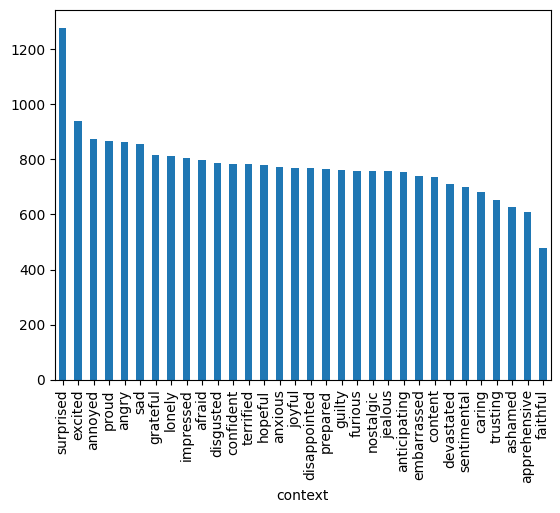

In [ ]:
# Distribution of contexts for human
(dial_human_tot.groupby("conv_id")
               .first()["context"]
               .value_counts()
               .plot.bar()
)


<Axes: xlabel='context'>

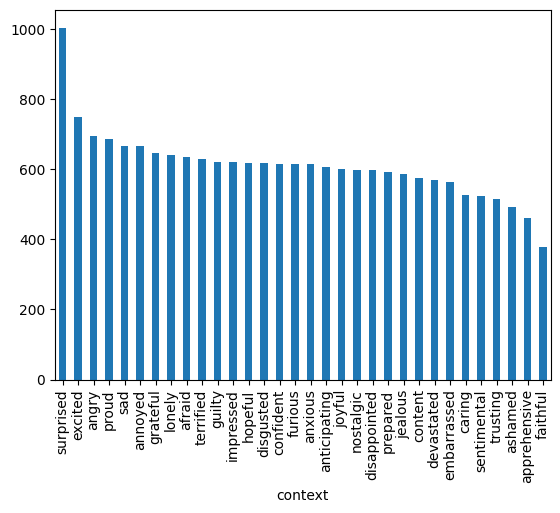

In [12]:
# Distribution of contexts for GPT
(dial_gpt2.groupby("conv_id")
               .first()["context"]
               .value_counts()
               .plot.bar()
)

<font color="red">1.2 Question:</font> Summarize your findings during the preprocessing process. Do you think we should include all the available contexts for our study? Why? 'Context' here refer to a column name in EmpatheticDialogue csv file.

<font color="orange">1.2 Answer:</font> 

In [ ]:
# To-do


<font color="red">2.1 Question:</font> Understand the prompting design used in 2GPTEmpathicDialogue generation. What are the advantages and limitations of this setting?

<font color="orange">2.1 Answer:</font> 

In [ ]:
# To-do

# <font color="green">**3 - Linguistic Feature for the Affective State between Participants**</font>

LSM is a linguistic feature related to affect analysis. You can add more as you like. You need to make sure each of your choice is supported by at least one published paper since the references are required. You need to check how to calculate each of the feature using dialogue text.

<font color="red">3.0 Question:</font> What is the affect analysis? What are possible scenario/application for affect analysis?

<font color="orange">3.0 Answer:</font> 

In [15]:
import spacy
from collections import defaultdict
import os
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "lemmatizer"])

n_cpus = os.cpu_count()
print(f"Using {n_cpus} CPU cores")

human_grouped = (
    dial_human_tot
    .groupby(["conv_id", "speaker_idx"])["utterance"]
    .apply(lambda x: " ".join(x))    # concatène toutes les utterances d'un même locuteur
    .reset_index()
)
gpt_grouped = (
    dial_gpt2
    .groupby(["conv_id", "speaker_idx"])["processed_split"]
    .apply(lambda x: " ".join(x))    # concatène toutes les utterances d'un même locuteur
    .reset_index()
)

human_docs = list(
    nlp.pipe(human_grouped["utterance"], batch_size=200, n_process=n_cpus)
)
gpt_docs = list(
    nlp.pipe(gpt_grouped["processed_split"], batch_size=200, n_process=n_cpus)
)


Using 10 CPU cores


,conv_id,utterance_idx,context,prompt,speaker_idx,utterance
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.
...,...,...,...,...,...,...
10968,hit:12416_conv:24832,4,disgusted,I saw a huge cockroach outside my house today....,46,I live in Texas to so i know those feels
10969,hit:12423_conv:24847,1,anxious,I have a big test on Monday. I am so nervous_c...,481,I have a big test on Monday_comma_ I am so ner...
10970,hit:12423_conv:24847,2,anxious,I have a big test on Monday. I am so nervous_c...,375,What is the test on?
10971,hit:12423_conv:24847,3,anxious,I have a big test on Monday. I am so nervous_c...,481,It's for my Chemistry class. I haven't slept m...


In [16]:
# Defining the pos tagging dictionary from the spacy en_core_web_sm dictionnary
CATEGORIES = {
    "pronouns": ["PRP", "PRP$", "WP", "WP$"],
    "articles": ["DT"],
    "prepositions": ["IN"],
    "aux_verbs": ["MD", "AUX"],
    "adverbs": ["RB", "RBR", "RBS"],
    "conjunctions": ["CC"],
    "negations": ["RB"],
}


TAG2CAT = {tag: cat for cat, tags in CATEGORIES.items() for tag in tags}

# Function returning the LSM score between two speakers. doc_A and doc_B are a spacy doc objects that are tokenized and pos-tagged
def conv_lsm_score(doc_A, doc_B):
    #Sub function returning a dict with categories as keys and number of words falling in each category as values for a sapcy doc object 
    def pos_freqs(doc):
        pos_counts = defaultdict(int)
        total = 0
        for token in doc:
            if token.is_alpha:
                total += 1
                cat = TAG2CAT.get(token.tag_)
                if cat:
                    pos_counts[cat] += 1
        return {cat: pos_counts[cat] / total if total > 0 else 0 for cat in CATEGORIES}

    freq_A = pos_freqs(doc_A)
    freq_B = pos_freqs(doc_B)

    lsm_scores = {
        cat: 1 - abs(freq_A[cat] - freq_B[cat]) / (freq_A[cat] + freq_B[cat] + 1e-5)
        for cat in CATEGORIES
    }

    return sum(lsm_scores.values()) / len(lsm_scores)

human_lsm_array = np.array([
    conv_lsm_score(human_docs[i], human_docs[i + 1])
    for i in range(0, len(human_docs) - 1, 2)
])

gpt_lsm_array = np.array([
    conv_lsm_score(gpt_docs[i], gpt_docs[i + 1])
    for i in range(0, len(gpt_docs) - 1, 2)
])

In [17]:
human_mean = human_lsm_array.mean()
gpt_mean = gpt_lsm_array.mean()
percent_diff = ((gpt_mean - human_mean) / human_mean) * 100
print(f"Human LSM mean: {human_mean:.4f}")
print(f"GPT LSM mean:   {gpt_mean:.4f}")
print(f"Delta GPT | Human = {percent_diff:.2f}%")

Human LSM mean: 0.6224
GPT LSM mean:   0.7896
Delta GPT | Human = 26.86%


<font color="red">3.1 Question:</font> How can the selected linguistic features be implemented for affective state analysis? If you use any open-source libraries or tools, please specify them and reference them in your code.

<font color="orange">3.1 Answer:</font> 

In [ ]:
# To-do

<font color="red">3.2 Question:</font> Is affective state impacted by scenario setting? What are the scenario that achieve highest affective state between human participants? Does ChatGPT generated conversation share the same answer?

<font color="orange">3.2 Answer:</font> 

<Axes: xlabel='context'>

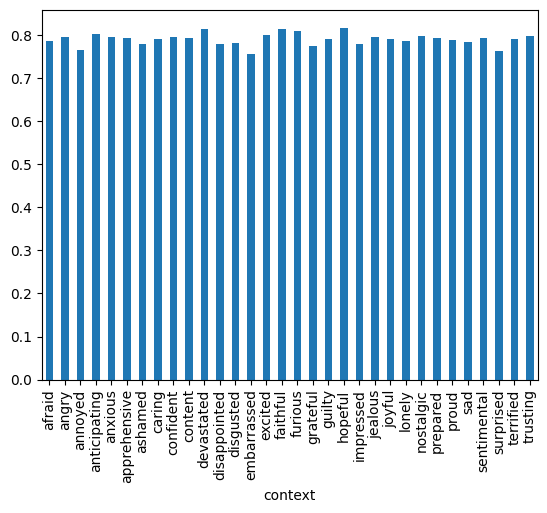

In [ ]:
dial_gpt['LSM'] = gpt_lsm_array
dial_gpt.groupby("context")["LSM"].mean().plot.bar()


In [49]:
single_utterance = human_grouped.groupby("conv_id").count().loc[human_grouped.groupby("conv_id").count()["speaker_idx"] == 1].index.to_list()
dial_human_tot2 = dial_human_tot.query("conv_id not in @single_utterance")
human_conv_context = dial_human_tot2.groupby("conv_id").first()


<font color="red">3.3 Question:</font> What are scenarios selected for this project? Why? 

<font color="orange">3.3 Answer:</font> 

# <font color="green">**4 - Modeling for ChatGPT-Generated Dialogue Detection**</font>

Our first baseline model can be defined since two corpora provide naturally labeled conversations.  

<font color="red">4.1 Question:</font> Which word embedding model is used by the paper? Why? Which word embedding model will you use? 

You can test several word embedding model and choos the one give you the best performance GPT generated dialogue classification.

<font color="orange">4.1 Answer:</font> 

In [ ]:
from sentence_transformers import SentenceTransformer
import pickle

dial_human_by_conv = dial_human_tot.groupby("conv_id").agg(
    utterance=('utterance', lambda x: ' '.join(x)), 
    context=('context', 'first'))

dial_human_by_conv = dial_human_by_conv[dial_human_by_conv.index.isin(dial_gpt['conv_id'])]
dial_tot_by_conv = pd.concat([dial_human_by_conv, dial_gpt.rename(columns={"processed": "utterance"})], join="inner", keys=[0, 1])


model = SentenceTransformer('all-MiniLM-L6-v2') # ou "all-mpnet-base-v2" ou 'intfloat/e5-large-v2'
embeddings_mini = model.encode(dial_tot_by_conv["utterance"].to_list(), normalize_embeddings=True, show_progress_bar=True)

# Sauvegarde
with open("embeddings_mini.pkl", "wb") as f:
    pickle.dump(embeddings_mini, f)
#    embeddings_mini = pickle.load(f)


Batches: 100%|██████████| 1221/1221 [01:53<00:00, 10.78it/s]


<font color="red">4.2 Question:</font> How to define the binary classification task? Test both linear and non-linear models to see which model provide better performance? You can follow the test, train, valid seperation defined inside Empatheticdiaogues corpus.

<font color="orange">4.2 Answer:</font> 

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(embeddings_mini, dial_tot_by_conv.index.get_level_values(0), random_state=0)
pipe = Pipeline([('logistic', LogisticRegression())])
pipe.fit(X_train, y_train).score(X_test, y_test)


/Users/andrew/MS_IA/NLP/human-gpt-linguistic-differences/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/andrew/MS_IA/NLP/human-gpt-linguistic-differences/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/andrew/MS_IA/NLP/human-gpt-linguistic-differences/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/andrew/MS_IA/NLP/human-gpt-linguistic-differences/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/andrew/MS_IA/NLP/human-gpt-linguistic-differences/.v

0.9954950342991706

In [94]:
dial_tot_by_conv.index.get_level_values(0)

Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       ...
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype='int64', length=39066)

<font color="red">4.3 Question:</font> What metrics do you use to evaluate your model's performance? What is the performance of your baseline model? In which scenario does your model achieve the best performance?Present the performance using appropriate graphs and visualizations where possible. 

<font color="orange">4.3 Answer:</font> 

In [ ]:
# To-do


# <font color="green">5 - Add Selected Features to Your Baseline Model</font>

Add calculated features into your baseline model. What is the performance if we use only the linguistic feature for our classification task? How to encode the features and add them to the existing word embedding?

<font color="red">5.1 Question:</font> Let's build a linear classifier using only the linguistic feature LSM. What are your best performance?  

List the tested linear classifier and their performance. Highlight the scenario that give best performance for each of them.

<font color="orange">5.1 Answer:</font> 

In [ ]:
# To-do

<font color="red">5.2 Question:</font> Try adding LSM to your baseline model. What is the nature of the calculated features (scaled, categorical, etc.)? How do you add them to the existing word embedding vector?

<font color="orange">5.2 Answer:</font> 

In [ ]:
# To-do

<font color="red">5.3 Question:</font> After adding LSM to your baseline model, are there any changes in the model's performance? How do you interpret the result? 

<font color="orange">5.3 Answer:</font> 

In [ ]:
# To-do

# <font color="green">**6 - Highlight Your Findings**</font>
This is an open question. Anything that stands out in your analysis should be highlighted. It could be a significant trend, an anomaly, or a correlation that was unexpected. Use visual aids like graphs or charts to make these findings clear and impactful.